In [91]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, RepeatedKFold, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.impute import KNNImputer
from sklearn.compose import TransformedTargetRegressor
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn import linear_model, svm

from itertools import combinations
from textwrap import wrap

# Exploring covariance between properties across scales
**Authors**: Benjamin Jasperson, Harley T. Johnson

**GitHub URL**: https://github.com/bjasperson/property-covariance-demo

# Background Information

why
compromise on modeling: accuracy/first-principles vs. speed and domain size.

what

goals

We're interested in uncovering relationships between fundamental microscopic properties and GB energy.
Desire a scalar value to compare against.
Derived a scaling coefficient.
For purposes here, you don't need to worry about how this coefficient is defined (see the paper for details).

# Download Data
To begin, we need to import our project data.
Collecting this data ....

The data we will use is originally from (this manuscript)[https://arxiv.org/abs/2411.16770], (published here)[https://doi.org/10.1016/j.actamat.2025.120722].

Download the CSV file and look at the first five rows.

In [92]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_data.csv?raw=true"
df_data = pd.read_csv(url_link, index_col=0)
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_fcc,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,1.058020,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,1.383830,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,0.841906,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,0.746775,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295


# Data review
It is important to get a feel for the data that you are working with. 


**Task**: explore different combinations of pairplots for the data. Identify any possible outliers for removal.

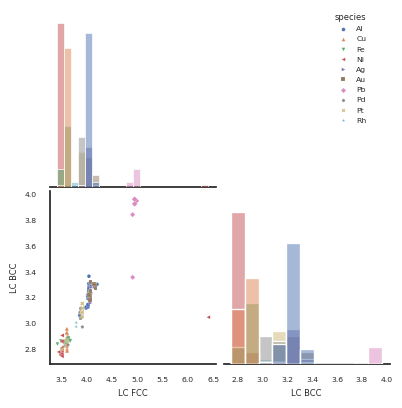

In [93]:
def pairplot_fun(df, 
                 params_list,  
                 label_dict, 
                 xlims = False, 
                 height=2.0):
    """create pairplot for select indicator properties

    Args:
        df (pandas.DataFrame): dataframe of data
        params_list (list): list of parameter strings to use
        label_dict (dict): convert label keys to human readable format
        xlims (list): list of limits to use for plotting
        height (float): pairplot height
    """
    params_list.extend(['species'])
    X = df[params_list]
    X.columns = [label_dict[x] for x in X.columns.to_list()]
    sns.set_theme(style="white", font_scale = .5)
    marker_list = ['o','^','v','<','>','s','D','p','X','*','.','P']
    g = sns.pairplot(X, hue='species', corner=True, markers = marker_list[0:len(df.species.drop_duplicates())],
                     plot_kws=dict(s=7, linewidth=0.1, rasterized = True), 
                     height=height,
                     diag_kind='hist')
    sns.move_legend(g, "upper right", bbox_to_anchor = (0.85,1))

    if xlims != False:
        for i in range(len(g.axes)):
            for j in range(len(g.axes[i])):
                g.axes[i][j].set_xlim(xlims)
                g.axes[i][j].set_ylim(xlims)


def import_label_dict():
    df_label_dict = pd.read_csv("./data/label_dict.csv")
    label_dict = df_label_dict.to_dict(orient="records")[0]
    return label_dict

label_dict = import_label_dict()
plot_param_list = ["lattice_constant_fcc", "lattice_constant_bcc"]
pairplot_fun(df_data, plot_param_list, label_dict)

# Identifying indicator properties

**Task**: run K-fold cross-validation. 

# Develop regression model

Linear regression versus SVR.

In [94]:
def factor_select_cv(X, y, pipe, n_factor_max=2, cv=5, scoring='r2'):
    """return list of parameters w/ cv score
    """
    factor_list = X.columns.to_list()
    subsets = []
    for n in range(1, (n_factor_max+1)):
        for subset in combinations(factor_list, n):
            subsets.append(list(subset))

    cv_score_mean = []
    cv_score_std = []
    num_factors = []
    for i, subset in enumerate(subsets):
        print(f"{i} of {len(subsets)}")
        print('current subset: ', subset)
        score = cross_val_score(pipe, X[subset], y, cv=cv, scoring=scoring, n_jobs = -1)
        print('score mean: ', np.mean(score))
        cv_score_mean.append(np.mean(score))
        cv_score_std.append(np.std(score))
        num_factors.append(len(subset))

    df_results = pd.DataFrame({'factors': subsets,
                               'num_factors': num_factors,
                               'cv_score': cv_score_mean,
                               'cv_score_std': cv_score_std})
    df_results = df_results.sort_values('cv_score', ascending=False)

    return df_results

In [95]:
params_list = ['lattice_constant_fcc',
                'bulk_modulus_fcc', 'c11_fcc', 'c12_fcc', 'c44_fcc',
                'extr_stack_fault_energy_fcc'
                ]

In [96]:
imput = KNNImputer(n_neighbors=2, weights="uniform",
                    keep_empty_features=True)

# Linear regression selection pipeline, used in manuscript
imput = KNNImputer(n_neighbors=2, weights="uniform",
                keep_empty_features=True)
model = linear_model.LinearRegression()

pipe = Pipeline(steps=[('scale', StandardScaler()),
                        ('imp', imput),
                        ('lr', model)])
# pipe = TransformedTargetRegressor(regressor=pipe,
#                                   transformer=StandardScaler())
filename = "kfold_models_lr"

X = df_data[params_list]
y = df_data['coeff']

n_factor_max = 2

cv = RepeatedKFold(n_splits=10, n_repeats=5)
df_results = factor_select_cv(X, 
                              y, 
                              pipe, 
                              n_factor_max=n_factor_max, 
                              cv=cv, 
                              scoring='neg_root_mean_squared_error')

#df_results.to_csv("./gb_covariance/model_ays/"+filename+".csv")

#factor_percent_usage(df_results, 100, filename)

0 of 21
current subset:  ['lattice_constant_fcc']
score mean:  -0.47417140525730367
1 of 21
current subset:  ['bulk_modulus_fcc']
score mean:  -0.45150206689778183
2 of 21
current subset:  ['c11_fcc']
score mean:  -0.45691378646540026
3 of 21
current subset:  ['c12_fcc']
score mean:  -0.4681293368037805
4 of 21
current subset:  ['c44_fcc']
score mean:  -0.36486403575648396
5 of 21
current subset:  ['extr_stack_fault_energy_fcc']
score mean:  -0.7816085319860089
6 of 21
current subset:  ['lattice_constant_fcc', 'bulk_modulus_fcc']
score mean:  -0.3896964166263776
7 of 21
current subset:  ['lattice_constant_fcc', 'c11_fcc']
score mean:  -0.390821254760993
8 of 21
current subset:  ['lattice_constant_fcc', 'c12_fcc']
score mean:  -0.3997600757428286
9 of 21
current subset:  ['lattice_constant_fcc', 'c44_fcc']
score mean:  -0.3601314666940473
10 of 21
current subset:  ['lattice_constant_fcc', 'extr_stack_fault_energy_fcc']
score mean:  -0.5547860103200222
11 of 21
current subset:  ['bulk_mo

In [97]:
df_results.sort_values("cv_score", ascending=False)

,factors,num_factors,cv_score,cv_score_std
18,"[c12_fcc, c44_fcc]",2,-0.343160,0.120224
13,"[bulk_modulus_fcc, c44_fcc]",2,-0.346448,0.135362
16,"[c11_fcc, c44_fcc]",2,-0.359120,0.138591
9,"[lattice_constant_fcc, c44_fcc]",2,-0.360131,0.108311
4,[c44_fcc],1,-0.364864,0.116967
6,"[lattice_constant_fcc, bulk_modulus_fcc]",2,-0.389696,0.090263
7,"[lattice_constant_fcc, c11_fcc]",2,-0.390821,0.126122
8,"[lattice_constant_fcc, c12_fcc]",2,-0.399760,0.080494
20,"[c44_fcc, extr_stack_fault_energy_fcc]",2,-0.406523,0.172376
1,[bulk_modulus_fcc],1,-0.451502,0.101537


Pick the top performing model and make a regression model to use. Make predictions and compare predicted versus actual.

In [98]:
pipe.fit(X[["c12_fcc", "c44_fcc"]], y)
y_pred = pipe.predict(X[["c12_fcc", "c44_fcc"]])
df_data['coeff_pred'] = y_pred

In [99]:
df_data.head()

,crystal_type,species,model,lattice_constant_bcc,lattice_constant_fcc,lattice_constant_sc,bulk_modulus_bcc,bulk_modulus_fcc,bulk_modulus_sc,c44_bcc,...,unrelaxed_formation_potential_energy_hcp,vacancy_migration_energy_bcc,vacancy_migration_energy_fcc,vacancy_migration_energy_hcp,vacancy_migration_energy_sc,relaxation_volume_bcc,relaxation_volume_fcc,relaxation_volume_hcp,coeff,coeff_pred
0,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_AlU__SM_...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610757,NaN,NaN,NaN,4.683538,NaN,1.191668,1.105830
1,fcc,Al,Sim_LAMMPS_MEAM_PascuetFernandez_2015_Al__SM_8...,3.270778,4.049999,2.740228,54.825677,78.890189,46.023445,34.077157,...,NaN,NaN,0.610485,NaN,NaN,NaN,4.681808,NaN,1.191794,1.105830
2,fcc,Al,Sim_LAMMPS_MEAM_AlmyrasSangiovanniSarakinos_20...,3.252540,4.047000,2.581950,71.601330,79.371087,61.759057,26.806281,...,NaN,NaN,0.573611,NaN,NaN,NaN,5.431662,NaN,0.691561,0.911980
3,fcc,Al,Sim_LAMMPS_MEAM_JelinekGrohHorstemeyer_2012_Al...,3.205723,4.049999,2.702319,81.620977,77.446258,51.141824,30.342210,...,NaN,NaN,0.496487,NaN,NaN,NaN,5.362940,NaN,1.134840,0.928668
4,fcc,Al,EAM_Dynamo_AngeloMoodyBaskes_1995_NiAlH__MO_41...,3.367689,4.050000,2.705041,83.092686,79.372122,86.368413,21.444173,...,NaN,NaN,0.179855,NaN,NaN,NaN,5.521970,NaN,0.495295,0.969453


Add from uncertainty_quantification_nested_cv

In [104]:
def pred_vs_actual_plot(df, 
                        figsize = (3,3),
                        ):
    sns.set_style("whitegrid")
    fig,ax = plt.subplots(figsize = (figsize[0],figsize[1]))
    sns.scatterplot(data=df, x='coeff', y='coeff_pred',hue='species',style = 'species')
    ax.plot(np.linspace(min(y),max(y),50),
           np.linspace(min(y),max(y),50))
    ax.set_xlabel(r"actual coefficient [$J/m^2$]", fontsize=8)
    ax.set_ylabel(r"predicted coefficient [$J/m^2$]", fontsize=8)
    ax.tick_params(labelsize=8)            

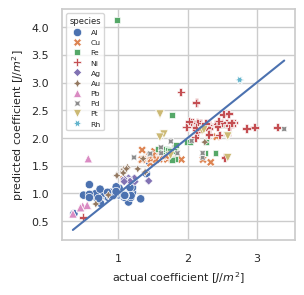

In [105]:
pred_vs_actual_plot(df_data)

# Make predictions from first-principles indicator properties

Import DFT data. 

Look at the DFT properties available and select the best 3 to make a model from.

In [ ]:
url_link = "https://github.com/bjasperson/property-covariance-demo/blob/main/data/gb_dft.csv?raw=true"
df_dft = pd.read_csv(url_link, index_col=0)
df_dft.head()

,species,bulk_modulus_fcc,c44_fcc,C11-C12,surface_energy_111_fcc,surface_energy_121_fcc,surface_energy_100_fcc,unstable_stack_energy_fcc,intr_stack_fault_energy_fcc,lattice_constant_fcc,relaxed_formation_potential_energy_fcc,vacancy_migration_energy_fcc,units,dft_exact_coeff
0,Ag,92.8612,41.2075,31.0503,0.044252,0.050806,0.049370,0.006472,0.001067,4.1457,0.7209,0.6564,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.032129
1,Al,76.0248,33.6604,53.4132,0.050868,0.059045,0.058608,0.010430,0.007602,4.0378,0.6413,0.3347,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.886213
2,Au,144.4053,26.5289,20.9309,0.043441,0.050244,0.054176,0.005418,0.001872,4.1539,0.2512,0.3986,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",0.842135
3,Cu,133.9783,79.5973,53.4236,0.080203,0.092686,0.090315,0.011104,0.002628,3.6239,0.8481,0.6623,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",1.551010
4,Ni,206.5840,117.5921,83.1221,0.114032,0.140808,0.139810,0.017851,0.008919,3.5036,1.2142,1.0189,"{‘bulk_modulus_unit_fcc’:’GPa’, ‘elastic_const...",2.302325


In [59]:
# best model of the 5 available DFT properties
model_properties = ['c44_fcc', 
                    #'intr_stack_fault_energy_fcc', 
                    #'unstable_stack_energy_fcc'
                    ]

Make prediction from DFT indicator properties, compare with the "true" DFT coefficient (calculated separately).

In [62]:
X_dft = df_dft[model_properties]
y_dft = df_dft['dft_exact_coeff']

pipe.fit(X[model_properties], y)

y_dft_pred = pipe.predict(X_dft)

below is from dft_import. Need to figure out what to roll in. Without prediction

In [ ]:
def get_boxplot(df_clean, 
                df_dft, 
                df_dft_gb,
                plot_errorbar = True,
                order_list = ["Ag","Al","Au","Cu","Ni","Pd","Pt"]):
    """plot boxplot of dft GB results
    """
    sns.set(style="whitegrid")
    fig, ax = plt.subplots(figsize=(4,3))
    sns.boxplot(data = df_clean, 
                x="species", 
                y="coeff", 
                order=order_list, 
                color = "0.8", 
                linewidth=1.0,
                fliersize=5.0,
                whis=0,
                flierprops={"marker":"."},
                zorder=1)
    ax.set_ylabel("GB scaling coefficient")

    # add dft Xs
    ax.scatter(df_dft['species'],
               df_dft['regr_coeff'], 
               marker='x', 
               s=100., 
               alpha=1.0, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ regression prediction using DFT indicator properties",20)),
               zorder=3)

    df_dft_gb_plot = df_dft_gb[['species','dft_exact_coeff']].drop_duplicates()
    df_dft_gb_plot = df_dft_gb_plot[df_dft_gb_plot['species'].isin(order_list)]
    ax.scatter(df_dft_gb_plot['species'],
               df_dft_gb_plot['dft_exact_coeff'], 
               marker='<', 
               s=50., 
               alpha=0.9, 
               color="r",
               label='\n'.join(wrap(r"$E_0$ fit directly to DFT GB results",20)),
               zorder=2)

    # add errorbars if desired
    if plot_errorbar == True:
        ax.errorbar(df_dft['species'],
                    df_dft['regr_coeff'], 
                    yerr = (df_dft['regr_coeff_lower'],
                            df_dft['regr_coeff_upper']), 
                            fmt='.', 
                            markersize=0.0001, 
                            alpha=0.5, 
                            color="r",
                            #label='\n'.join(wrap("Predicted strength using DFT indicator properties",20)),
                            elinewidth=2.0,
                            capsize = 4)

    fig.legend(bbox_to_anchor = (0.05,0.9,0.85,.15),#(0.,1.02,1.,.102),
                    loc='lower left',
                    mode="expand",
                    #bbox_transform = fig.transFigure)
                    ncol = 2,
                    fontsize= 8)
    # ax.legend(new_handles, labels, fontsize=8)

    return 